<a href="https://colab.research.google.com/github/HusseinChawich/CBM_model/blob/main/CBM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Concept Bottleneck Models (CBM) - Practical Demonstration

In this notebook, we will:
1. Load and prepare a medical imaging dataset (CheXpert)
2. Train a standard CNN (baseline)
3. Train a CBM with clinical concepts
4. Compare performance and interpretability
5. Perform concept intervention experiments

# 1. Setup and Installation

Install required packages

In [1]:
# install_with_verbose.py
import subprocess
import sys

# Create a requirements.txt file with version specifications to avoid conflicts
requirements = """numpy>=1.21.0
torch>=2.0.0
torchvision>=0.15.0
torchaudio>=2.0.0
pandas>=1.3.0
matplotlib>=3.5.0
seaborn>=0.11.0
scikit-learn>=1.0.0
Pillow>=9.0.0
opencv-python>=4.5.0
captum>=0.6.0
"""

# Write to requirements file
with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt created successfully!")
print("-" * 50)
print("Contents of requirements.txt:")
print(requirements)
print("-" * 50)

# Install from the requirements file with verbose output
print("Installing packages...")
print("This may take several minutes depending on your internet connection.")
print("=" * 50)

# Use subprocess.run with capture_output to show installation progress
result = subprocess.run(
    [sys.executable, "-m", "pip", "install", "-r", "requirements.txt"],
    capture_output=True,
    text=True
)

print("Installation output:")
print(result.stdout)
if result.stderr:
    print("Errors/Warnings:")
    print(result.stderr)
print(f"Exit code: {result.returncode}")

if result.returncode == 0:
    print("\n✅ All packages installed successfully!")
else:
    print("\n❌ Installation failed. Trying alternative approach...")

requirements.txt created successfully!
--------------------------------------------------
Contents of requirements.txt:
numpy>=1.21.0
torch>=2.0.0
torchvision>=0.15.0
torchaudio>=2.0.0
pandas>=1.3.0
matplotlib>=3.5.0
seaborn>=0.11.0
scikit-learn>=1.0.0
Pillow>=9.0.0
opencv-python>=4.5.0
captum>=0.6.0

--------------------------------------------------
Installing packages...
This may take several minutes depending on your internet connection.
Installation output:
INFO: pip is looking at multiple versions of captum to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00

Exit code: 0

✅ All packages installed successfully!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models as torchvision_models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import os
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 2. Dataset Preparation

We'll use a simplified version of the CheXpert dataset with synthetic concepts for demonstration.



In [3]:
# Create a synthetic dataset for demonstration
# In practice, you would use the actual CheXpert dataset
!mkdir -p sample_data
!mkdir -p sample_data/images

*   Generate synthetic chest X-ray images and concept labels
*   This is a simplified version for demonstration purposes

Why using a mimicked data?


*   No need to download large datasets (5-10GB+ for CheXpert)
*   Generates data instantly vs downloading hours
*   No complex data preprocessing (CheXpert requires significant cleanup)
*   Same data every time, no dataset version issues



In [4]:
class SyntheticCheXpertDataset(Dataset):
    """Synthetic dataset mimicking CheXpert for CBM demonstration"""

    def __init__(self, num_samples=1000, split='train', img_size=(224, 224)):
        self.num_samples = num_samples
        self.split = split
        self.img_size = img_size

        # Define concepts (clinical findings)
        self.concept_names = [
            'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
            'Pleural Effusion', 'Pneumonia', 'Pneumothorax'
        ]

        # Disease labels (multiple diseases possible)
        self.disease_names = [
            'Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
            'Pleural Effusion', 'Pneumonia', 'Pneumothorax', 'No Finding'
        ]

        # Generate synthetic data
        self.data = self._generate_data()

        # Image transformations
        if split == 'train':
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(self.img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
            ])

    def _generate_data(self):
        """Generate synthetic dataset with correlations between concepts and diseases"""
        data = []

        for i in range(self.num_samples):
            # Randomly generate concepts with some correlations
            concepts = np.random.binomial(1, 0.2, size=len(self.concept_names)).astype(float)

            # Create disease labels based on concepts with some noise
            # Each disease is primarily associated with its corresponding concept
            diseases = np.zeros(len(self.disease_names))

            # Map concepts to diseases (simplified mapping)
            for j in range(len(self.concept_names)):
                if j < len(self.concept_names) - 1:  # Map concept to disease
                    # Disease probability depends on concept presence
                    disease_prob = concepts[j] * 0.8 + np.random.random() * 0.2
                    diseases[j] = 1.0 if disease_prob > 0.5 else 0.0

            # Add "No Finding" if no diseases
            if diseases.sum() == 0:
                diseases[-1] = 1.0

            # Create synthetic "image" path
            img_path = f"sample_data/images/{self.split}_img_{i}.npy"

            data.append({
                'img_path': img_path,
                'concepts': concepts,
                'diseases': diseases,
                'patient_id': i
            })

        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Generate synthetic image (in practice, this would be a real X-ray)
        # We create a synthetic image with patterns based on concepts
        img = self._generate_synthetic_image(sample['concepts'])

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        concepts = torch.FloatTensor(sample['concepts'])
        diseases = torch.FloatTensor(sample['diseases'])

        return img, concepts, diseases, idx

    def _generate_synthetic_image(self, concepts):
        """Generate a synthetic chest X-ray image based on concepts"""
        # Create a base image (simulating chest X-ray)
        img_size = (self.img_size[0], self.img_size[1], 3)
        img = np.zeros(img_size, dtype=np.uint8)

        # Add lungs (elliptical shapes)
        center_y, center_x = img_size[0]//2, img_size[1]//2
        lung_width, lung_height = img_size[1]//3, img_size[0]//3

        # Left lung
        cv_x, cv_y = center_x - lung_width//2, center_y
        for y in range(max(0, cv_y - lung_height//2), min(img_size[0], cv_y + lung_height//2)):
            for x in range(max(0, cv_x - lung_width//4), min(img_size[1], cv_x + lung_width//4)):
                dist = ((x - cv_x)/(lung_width/4))**2 + ((y - cv_y)/(lung_height/2))**2
                if dist <= 1:
                    intensity = 150 + random.randint(-20, 20)
                    img[y, x] = [intensity, intensity, intensity]

        # Right lung
        cv_x, cv_y = center_x + lung_width//2, center_y
        for y in range(max(0, cv_y - lung_height//2), min(img_size[0], cv_y + lung_height//2)):
            for x in range(max(0, cv_x - lung_width//4), min(img_size[1], cv_x + lung_width//4)):
                dist = ((x - cv_x)/(lung_width/4))**2 + ((y - cv_y)/(lung_height/2))**2
                if dist <= 1:
                    intensity = 150 + random.randint(-20, 20)
                    img[y, x] = [intensity, intensity, intensity]

        # Add heart shadow
        cv_x, cv_y = center_x - lung_width//6, center_y
        heart_radius = lung_height//4
        for y in range(max(0, cv_y - heart_radius), min(img_size[0], cv_y + heart_radius)):
            for x in range(max(0, cv_x - heart_radius), min(img_size[1], cv_x + heart_radius)):
                dist = ((x - cv_x)/heart_radius)**2 + ((y - cv_y)/heart_radius)**2
                if dist <= 1:
                    intensity = 100 + random.randint(-10, 10)
                    img[y, x] = [intensity, intensity, intensity]

        # Add abnormalities based on concepts
        for i, concept_present in enumerate(concepts):
            if concept_present > 0.5:
                # Add visual patterns for each concept
                if i == 0:  # Cardiomegaly - enlarged heart
                    cv_x, cv_y = center_x - lung_width//6, center_y
                    enlarged_radius = int(heart_radius * 1.5)
                    for y in range(max(0, cv_y - enlarged_radius), min(img_size[0], cv_y + enlarged_radius)):
                        for x in range(max(0, cv_x - enlarged_radius), min(img_size[1], cv_x + enlarged_radius)):
                            dist = ((x - cv_x)/enlarged_radius)**2 + ((y - cv_y)/enlarged_radius)**2
                            if dist <= 1:
                                img[y, x] = np.clip(img[y, x] - 30, 0, 255)

                elif i == 4:  # Pleural Effusion - fluid in lungs
                    # Add blurry areas at lung bases
                    for lung_base in [center_y + lung_height//3]:
                        for x in range(center_x - lung_width, center_x + lung_width):
                            if 0 <= x < img_size[1] and 0 <= lung_base < img_size[0]:
                                img[lung_base:min(lung_base+10, img_size[0]),
                                    max(0, x-5):min(x+5, img_size[1])] = 80

        # Convert to PIL Image
        img_pil = Image.fromarray(img.astype(np.uint8))
        return img_pil

# Create datasets
train_dataset = SyntheticCheXpertDataset(num_samples=800, split='train')
val_dataset = SyntheticCheXpertDataset(num_samples=100, split='val')
test_dataset = SyntheticCheXpertDataset(num_samples=100, split='test')

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of concepts: {len(train_dataset.concept_names)}")
print(f"Number of diseases: {len(train_dataset.disease_names)}")
print("\nConcept names:", train_dataset.concept_names)
print("\nDisease names:", train_dataset.disease_names)

Train samples: 800
Val samples: 100
Test samples: 100
Number of concepts: 7
Number of diseases: 8

Concept names: ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax']

Disease names: ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Pneumonia', 'Pneumothorax', 'No Finding']


# 3. Visualize Sample Data

Training samples:


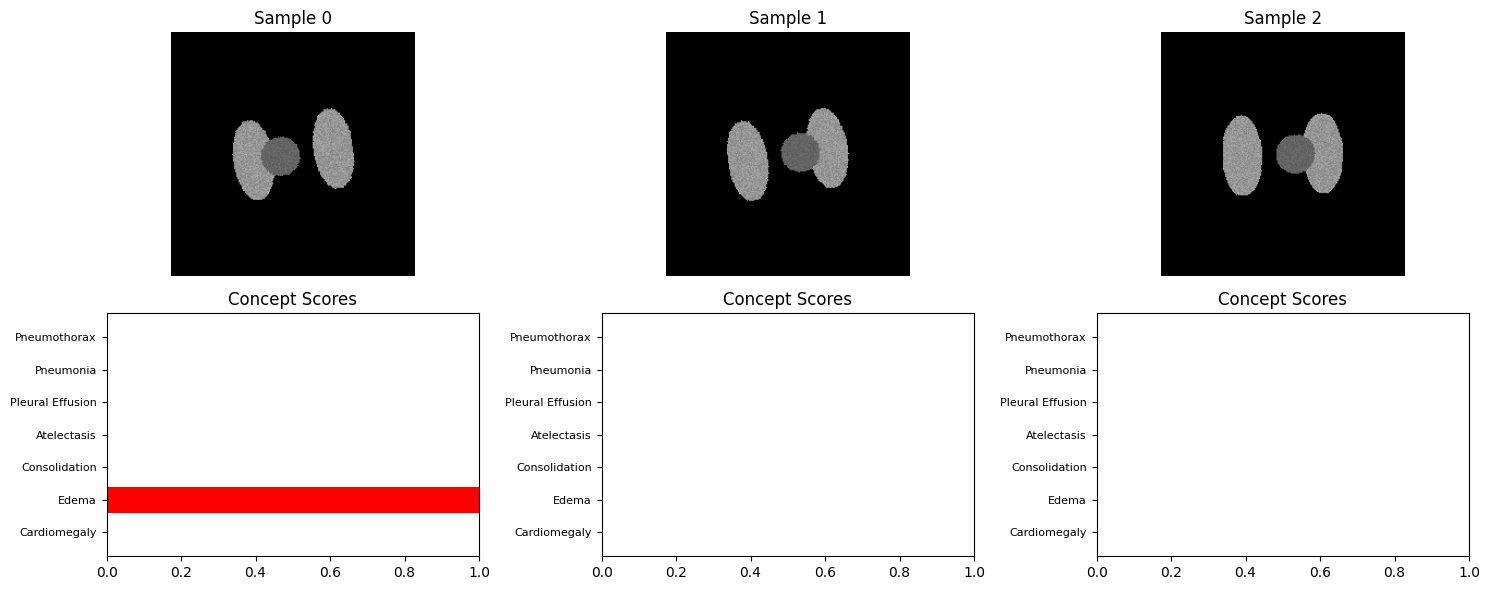

In [5]:
# Visualize some samples with their concept labels
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i in range(num_samples):
        img, concepts, diseases, idx = dataset[i]

        # Display image
        ax_img = axes[0, i] if num_samples > 1 else axes[0]
        # Denormalize image
        img_np = img.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        ax_img.imshow(img_np)
        ax_img.set_title(f"Sample {i}")
        ax_img.axis('off')

        # Display concepts
        ax_concepts = axes[1, i] if num_samples > 1 else axes[1]
        concept_mask = concepts.numpy() > 0.5
        colors = ['red' if present else 'gray' for present in concept_mask]
        y_pos = np.arange(len(dataset.concept_names))

        ax_concepts.barh(y_pos, concepts.numpy(), color=colors)
        ax_concepts.set_yticks(y_pos)
        ax_concepts.set_yticklabels(dataset.concept_names, fontsize=8)
        ax_concepts.set_xlim(0, 1)
        ax_concepts.set_title("Concept Scores")

    plt.tight_layout()
    plt.show()

print("Training samples:")
visualize_samples(train_dataset, 3)

# 4. Model Definitions

## Standard CNN Baseline Model

In [6]:
# Standard CNN Baseline Model
class BaselineCNN(nn.Module):
    """Standard CNN that directly predicts diseases from images"""

    def __init__(self, num_diseases, pretrained=True):
        super(BaselineCNN, self).__init__()

        # Use ResNet-18 as backbone
        if pretrained:
            self.backbone = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.IMAGENET1K_V1)
            # Freeze early layers (optional)
            for param in self.backbone.parameters():
                param.requires_grad = True
        else:
            self.backbone = torchvision_models.resnet18(weights=None)

        # Replace final layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove original fully connected layer

        # Disease classifier
        self.disease_classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_diseases),
            nn.Sigmoid()  # Multi-label classification
        )

    def forward(self, x):
        features = self.backbone(x)
        disease_pred = self.disease_classifier(features)
        return disease_pred

## Concept Bottleneck Model (CBM)

In [7]:
# Concept Bottleneck Model (CBM)
class ConceptBottleneckModel(nn.Module):
    """CBM that predicts concepts first, then uses them to predict diseases"""

    def __init__(self, num_concepts, num_diseases, pretrained=True, bottleneck_type='joint'):
        """
        Args:
            bottleneck_type: 'joint' (train both stages together),
                           'sequential' (train concept predictor first),
                           'independent' (train concept predictor, then freeze)
        """
        super(ConceptBottleneckModel, self).__init__()
        self.bottleneck_type = bottleneck_type
        self.num_concepts = num_concepts

        # Use ResNet-18 as backbone
        if pretrained:
            self.backbone = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.IMAGENET1K_V1)
            # Freeze early layers (optional)
            for param in self.backbone.parameters():
                param.requires_grad = True
        else:
            self.backbone = torchvision_models.resnet18(weights=None)

        # Replace final layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Remove original fully connected layer

        # Concept predictor
        self.concept_predictor = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_concepts),
            nn.Sigmoid()  # Multi-label classification for concepts
        )

        # Disease predictor (uses concept predictions as input)
        self.disease_predictor = nn.Sequential(
            nn.Linear(num_concepts, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_diseases),
            nn.Sigmoid()  # Multi-label classification for diseases
        )

    def forward(self, x, concepts_gt=None, intervention_mask=None, intervention_values=None):
        """
        Forward pass for CBM

        Args:
            x: Input images
            concepts_gt: Ground truth concepts (for intervention or sequential training)
            intervention_mask: Boolean mask indicating which concepts to intervene on
            intervention_values: Values to use for intervened concepts
        """
        # Extract image features
        features = self.backbone(x)

        # Predict concepts
        concept_pred = self.concept_predictor(features)

        # Apply intervention if specified
        if intervention_mask is not None and intervention_values is not None:
            concept_pred = torch.where(intervention_mask, intervention_values, concept_pred)
        elif concepts_gt is not None and self.training and self.bottleneck_type == 'sequential':
            # During sequential training, use ground truth concepts
            concept_pred = concepts_gt

        # Predict diseases from concepts
        disease_pred = self.disease_predictor(concept_pred)

        return disease_pred, concept_pred

## Hybrid CBM (can also use image features directly)

In [8]:
# Hybrid CBM (can also use image features directly)
class HybridCBM(nn.Module):
    """Hybrid CBM that uses both concepts and image features for disease prediction"""

    def __init__(self, num_concepts, num_diseases, pretrained=True):
        super(HybridCBM, self).__init__()

        # Use ResNet-18 as backbone
        if pretrained:
            self.backbone = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.IMAGENET1K_V1)
            for param in self.backbone.parameters():
                param.requires_grad = True
        else:
            self.backbone = torchvision_models.resnet18(weights=None)

        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Concept predictor
        self.concept_predictor = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_concepts),
            nn.Sigmoid()
        )

        # Disease predictor (uses both concepts AND image features)
        self.disease_predictor = nn.Sequential(
            nn.Linear(num_concepts + num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_diseases),
            nn.Sigmoid()
        )

    def forward(self, x, concepts_gt=None, intervention_mask=None, intervention_values=None):
        # Extract image features
        features = self.backbone(x)

        # Predict concepts
        concept_pred = self.concept_predictor(features)

        # Apply intervention if specified
        if intervention_mask is not None and intervention_values is not None:
            concept_pred = torch.where(intervention_mask, intervention_values, concept_pred)

        # Concatenate concepts and features
        combined = torch.cat([concept_pred, features], dim=1)

        # Predict diseases
        disease_pred = self.disease_predictor(combined)

        return disease_pred, concept_pred

# 5. Training Functions

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, device, model_type='baseline'):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    all_disease_preds = []
    all_disease_labels = []

    for batch_idx, (images, concepts, diseases, _) in enumerate(dataloader):
        images, concepts, diseases = images.to(device), concepts.to(device), diseases.to(device)

        optimizer.zero_grad()

        if model_type == 'baseline':
            disease_pred = model(images)
            loss = criterion(disease_pred, diseases)
        else:  # CBM or HybridCBM
            disease_pred, concept_pred = model(images)

            # Combined loss: disease prediction loss + concept prediction loss
            disease_loss = criterion(disease_pred, diseases)
            concept_loss = criterion(concept_pred, concepts)

            # Weighted combination
            loss = disease_loss + 0.5 * concept_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Collect predictions for metrics
        all_disease_preds.append(disease_pred.detach().cpu())
        all_disease_labels.append(diseases.detach().cpu())

    # Calculate epoch metrics
    all_disease_preds = torch.cat(all_disease_preds, dim=0)
    all_disease_labels = torch.cat(all_disease_labels, dim=0)

    # Calculate accuracy (threshold at 0.5)
    disease_acc = ((all_disease_preds > 0.5) == (all_disease_labels > 0.5)).float().mean().item()

    return running_loss / len(dataloader), disease_acc

def evaluate(model, dataloader, criterion, device, model_type='baseline'):
    """Evaluate model"""
    model.eval()
    running_loss = 0.0
    all_disease_preds = []
    all_disease_labels = []
    all_concept_preds = []
    all_concept_labels = []

    with torch.no_grad():
        for images, concepts, diseases, _ in dataloader:
            images, concepts, diseases = images.to(device), concepts.to(device), diseases.to(device)

            if model_type == 'baseline':
                disease_pred = model(images)
                loss = criterion(disease_pred, diseases)
                concept_pred = None
            else:  # CBM or HybridCBM
                disease_pred, concept_pred = model(images)

                # Combined loss
                disease_loss = criterion(disease_pred, diseases)
                concept_loss = criterion(concept_pred, concepts)
                loss = disease_loss + 0.5 * concept_loss

            running_loss += loss.item()

            # Collect predictions
            all_disease_preds.append(disease_pred.cpu())
            all_disease_labels.append(diseases.cpu())

            if concept_pred is not None:
                all_concept_preds.append(concept_pred.cpu())
                all_concept_labels.append(concepts.cpu())

    # Concatenate all predictions
    all_disease_preds = torch.cat(all_disease_preds, dim=0)
    all_disease_labels = torch.cat(all_disease_labels, dim=0)

    # Calculate metrics
    disease_acc = ((all_disease_preds > 0.5) == (all_disease_labels > 0.5)).float().mean().item()

    # Calculate AUC for each disease (multi-label)
    disease_aucs = []
    for i in range(all_disease_labels.shape[1]):
        try:
            auc = roc_auc_score(all_disease_labels[:, i].numpy(), all_disease_preds[:, i].numpy())
            disease_aucs.append(auc)
        except:
            disease_aucs.append(0.5)

    avg_disease_auc = np.mean(disease_aucs)

    # Calculate concept accuracy if available
    concept_acc = None
    if all_concept_preds:
        all_concept_preds = torch.cat(all_concept_preds, dim=0)
        all_concept_labels = torch.cat(all_concept_labels, dim=0)
        concept_acc = ((all_concept_preds > 0.5) == (all_concept_labels > 0.5)).float().mean().item()

    return running_loss / len(dataloader), disease_acc, avg_disease_auc, concept_acc

# 6. Train Baseline CNN

In [10]:
# Initialize baseline model
num_diseases = len(train_dataset.disease_names)
baseline_model = BaselineCNN(num_diseases, pretrained=True).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label classification
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
print("Training Baseline CNN...")
num_epochs = 15
baseline_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(baseline_model, train_loader, optimizer, criterion, device, 'baseline')

    # Validate
    val_loss, val_acc, val_auc, _ = evaluate(baseline_model, val_loader, criterion, device, 'baseline')

    # Update scheduler
    scheduler.step()

    # Store history
    baseline_history['train_loss'].append(train_loss)
    baseline_history['val_loss'].append(val_loss)
    baseline_history['train_acc'].append(train_acc)
    baseline_history['val_acc'].append(val_acc)
    baseline_history['val_auc'].append(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

# Test baseline model
print("\nTesting Baseline CNN...")
test_loss, test_acc, test_auc, _ = evaluate(baseline_model, test_loader, criterion, device, 'baseline')
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 145MB/s]


Training Baseline CNN...
Epoch 1/15: Train Loss: 0.3699, Train Acc: 0.8427, Val Loss: 0.3495, Val Acc: 0.8600, Val AUC: nan
Epoch 2/15: Train Loss: 0.3242, Train Acc: 0.8630, Val Loss: 0.3081, Val Acc: 0.8450, Val AUC: nan
Epoch 3/15: Train Loss: 0.3176, Train Acc: 0.8641, Val Loss: 0.3014, Val Acc: 0.8612, Val AUC: nan
Epoch 4/15: Train Loss: 0.3146, Train Acc: 0.8641, Val Loss: 0.2929, Val Acc: 0.8612, Val AUC: nan
Epoch 5/15: Train Loss: 0.3174, Train Acc: 0.8625, Val Loss: 1.7083, Val Acc: 0.7412, Val AUC: nan
Epoch 6/15: Train Loss: 0.3140, Train Acc: 0.8636, Val Loss: 0.3042, Val Acc: 0.8612, Val AUC: nan
Epoch 7/15: Train Loss: 0.3139, Train Acc: 0.8655, Val Loss: 0.3004, Val Acc: 0.8612, Val AUC: nan
Epoch 8/15: Train Loss: 0.3091, Train Acc: 0.8650, Val Loss: 0.2913, Val Acc: 0.8612, Val AUC: nan
Epoch 9/15: Train Loss: 0.3089, Train Acc: 0.8683, Val Loss: 0.2917, Val Acc: 0.8612, Val AUC: nan
Epoch 10/15: Train Loss: 0.3081, Train Acc: 0.8666, Val Loss: 0.2961, Val Acc: 0.861

# 7. Train Concept Bottleneck Model

In [11]:
# Initialize CBM
num_concepts = len(train_dataset.concept_names)
cbm_model = ConceptBottleneckModel(num_concepts, num_diseases, pretrained=True, bottleneck_type='joint').to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(cbm_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
print("Training Concept Bottleneck Model (Joint Training)...")
num_epochs = 15
cbm_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': [], 'concept_acc': []}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(cbm_model, train_loader, optimizer, criterion, device, 'cbm')

    # Validate
    val_loss, val_acc, val_auc, concept_acc = evaluate(cbm_model, val_loader, criterion, device, 'cbm')

    # Update scheduler
    scheduler.step()

    # Store history
    cbm_history['train_loss'].append(train_loss)
    cbm_history['val_loss'].append(val_loss)
    cbm_history['train_acc'].append(train_acc)
    cbm_history['val_acc'].append(val_acc)
    cbm_history['val_auc'].append(val_auc)
    cbm_history['concept_acc'].append(concept_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, "
          f"Concept Acc: {concept_acc:.4f}")

# Test CBM model
print("\nTesting Concept Bottleneck Model...")
test_loss, test_acc, test_auc, test_concept_acc = evaluate(cbm_model, test_loader, criterion, device, 'cbm')
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}, Concept Acc: {test_concept_acc:.4f}")

Training Concept Bottleneck Model (Joint Training)...
Epoch 1/15: Train Loss: 0.8520, Train Acc: 0.7487, Val Loss: 1.6185, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.7129
Epoch 2/15: Train Loss: 0.7580, Train Acc: 0.8163, Val Loss: 0.7425, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.8300
Epoch 3/15: Train Loss: 0.6955, Train Acc: 0.8159, Val Loss: 0.6991, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.8300
Epoch 4/15: Train Loss: 0.6470, Train Acc: 0.8159, Val Loss: 0.6183, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.8500
Epoch 5/15: Train Loss: 0.6173, Train Acc: 0.8161, Val Loss: 0.6471, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.8286
Epoch 6/15: Train Loss: 0.5982, Train Acc: 0.8181, Val Loss: 0.5765, Val Acc: 0.8188, Val AUC: nan, Concept Acc: 0.8500
Epoch 7/15: Train Loss: 0.5788, Train Acc: 0.8291, Val Loss: 0.5558, Val Acc: 0.8425, Val AUC: nan, Concept Acc: 0.8500
Epoch 8/15: Train Loss: 0.5630, Train Acc: 0.8478, Val Loss: 0.5424, Val Acc: 0.8612, Val AUC: nan, Concep

# 8. Train Hybrid CBM

In [12]:
# Initialize Hybrid CBM
hybrid_model = HybridCBM(num_concepts, num_diseases, pretrained=True).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training loop
print("Training Hybrid CBM...")
num_epochs = 15
hybrid_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': [], 'concept_acc': []}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(hybrid_model, train_loader, optimizer, criterion, device, 'cbm')

    # Validate
    val_loss, val_acc, val_auc, concept_acc = evaluate(hybrid_model, val_loader, criterion, device, 'cbm')

    # Update scheduler
    scheduler.step()

    # Store history
    hybrid_history['train_loss'].append(train_loss)
    hybrid_history['val_loss'].append(val_loss)
    hybrid_history['train_acc'].append(train_acc)
    hybrid_history['val_acc'].append(val_acc)
    hybrid_history['val_auc'].append(val_auc)
    hybrid_history['concept_acc'].append(concept_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}, "
          f"Concept Acc: {concept_acc:.4f}")

# Test Hybrid CBM model
print("\nTesting Hybrid CBM...")
test_loss, test_acc, test_auc, test_concept_acc = evaluate(hybrid_model, test_loader, criterion, device, 'cbm')
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}, Concept Acc: {test_concept_acc:.4f}")

Training Hybrid CBM...
Epoch 1/15: Train Loss: 0.5881, Train Acc: 0.8420, Val Loss: 11.4604, Val Acc: 0.7375, Val AUC: nan, Concept Acc: 0.7343
Epoch 2/15: Train Loss: 0.5161, Train Acc: 0.8605, Val Loss: 0.5410, Val Acc: 0.8450, Val AUC: nan, Concept Acc: 0.8500
Epoch 3/15: Train Loss: 0.5033, Train Acc: 0.8645, Val Loss: 0.4855, Val Acc: 0.8450, Val AUC: nan, Concept Acc: 0.8500
Epoch 4/15: Train Loss: 0.4973, Train Acc: 0.8642, Val Loss: 0.4805, Val Acc: 0.8612, Val AUC: nan, Concept Acc: 0.8500
Epoch 5/15: Train Loss: 0.4944, Train Acc: 0.8628, Val Loss: 0.4844, Val Acc: 0.8612, Val AUC: nan, Concept Acc: 0.8500
Epoch 6/15: Train Loss: 0.4972, Train Acc: 0.8686, Val Loss: 0.5066, Val Acc: 0.8612, Val AUC: nan, Concept Acc: 0.8486
Epoch 7/15: Train Loss: 0.4913, Train Acc: 0.8667, Val Loss: 0.4967, Val Acc: 0.8612, Val AUC: nan, Concept Acc: 0.8500
Epoch 8/15: Train Loss: 0.4882, Train Acc: 0.8652, Val Loss: 0.4863, Val Acc: 0.8612, Val AUC: nan, Concept Acc: 0.8500
Epoch 9/15: Trai

# 9. Compare Models

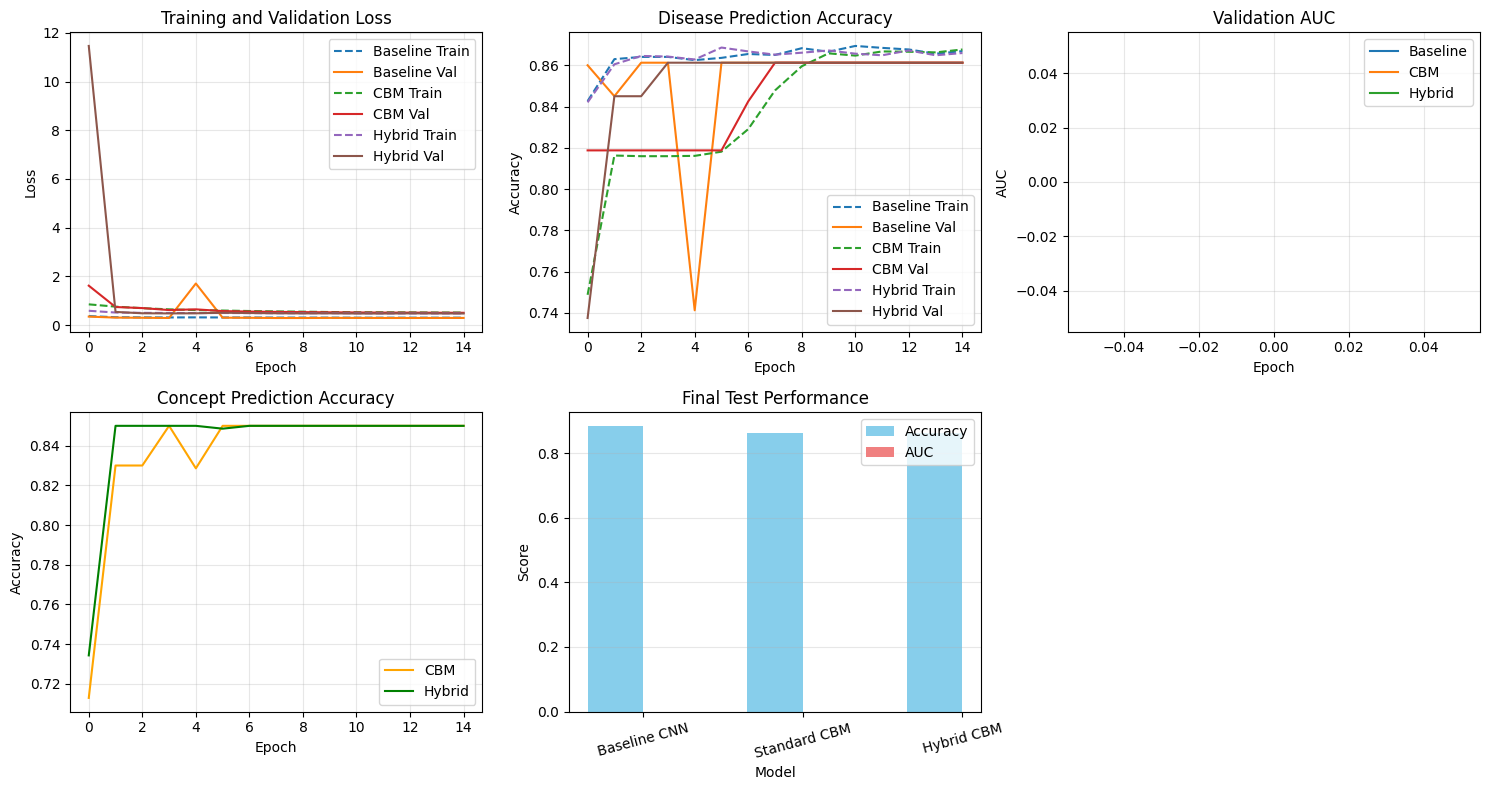

MODEL PERFORMANCE SUMMARY
Model                Disease Acc     Disease AUC     Concept Acc    
------------------------------------------------------------
Baseline CNN         0.8825           nan           N/A            
Standard CBM         0.8612           nan           0.8500          
Hybrid CBM           0.8612           nan           0.8500          


In [13]:
# Plot training history comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot loss
axes[0, 0].plot(baseline_history['train_loss'], label='Baseline Train', linestyle='--')
axes[0, 0].plot(baseline_history['val_loss'], label='Baseline Val')
axes[0, 0].plot(cbm_history['train_loss'], label='CBM Train', linestyle='--')
axes[0, 0].plot(cbm_history['val_loss'], label='CBM Val')
axes[0, 0].plot(hybrid_history['train_loss'], label='Hybrid Train', linestyle='--')
axes[0, 0].plot(hybrid_history['val_loss'], label='Hybrid Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot accuracy
axes[0, 1].plot(baseline_history['train_acc'], label='Baseline Train', linestyle='--')
axes[0, 1].plot(baseline_history['val_acc'], label='Baseline Val')
axes[0, 1].plot(cbm_history['train_acc'], label='CBM Train', linestyle='--')
axes[0, 1].plot(cbm_history['val_acc'], label='CBM Val')
axes[0, 1].plot(hybrid_history['train_acc'], label='Hybrid Train', linestyle='--')
axes[0, 1].plot(hybrid_history['val_acc'], label='Hybrid Val')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Disease Prediction Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot AUC
axes[0, 2].plot(baseline_history['val_auc'], label='Baseline')
axes[0, 2].plot(cbm_history['val_auc'], label='CBM')
axes[0, 2].plot(hybrid_history['val_auc'], label='Hybrid')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].set_title('Validation AUC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot concept accuracy for CBMs
axes[1, 0].plot(cbm_history['concept_acc'], label='CBM', color='orange')
axes[1, 0].plot(hybrid_history['concept_acc'], label='Hybrid', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Concept Prediction Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Final test performance comparison
models = ['Baseline CNN', 'Standard CBM', 'Hybrid CBM']
test_accs = [test_acc, cbm_history['val_acc'][-1], hybrid_history['val_acc'][-1]]
test_aucs = [test_auc, cbm_history['val_auc'][-1], hybrid_history['val_auc'][-1]]

x = np.arange(len(models))
width = 0.35

axes[1, 1].bar(x - width/2, test_accs, width, label='Accuracy', color='skyblue')
axes[1, 1].bar(x + width/2, test_aucs, width, label='AUC', color='lightcoral')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Final Test Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models, rotation=15)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Print performance summary
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Model':<20} {'Disease Acc':<15} {'Disease AUC':<15} {'Concept Acc':<15}")
print("-"*60)
print(f"{'Baseline CNN':<20} {test_acc:.4f}{'':<10} {test_auc:.4f}{'':<10} {'N/A':<15}")
print(f"{'Standard CBM':<20} {cbm_history['val_acc'][-1]:.4f}{'':<10} {cbm_history['val_auc'][-1]:.4f}{'':<10} {cbm_history['concept_acc'][-1]:.4f}{'':<10}")
print(f"{'Hybrid CBM':<20} {hybrid_history['val_acc'][-1]:.4f}{'':<10} {hybrid_history['val_auc'][-1]:.4f}{'':<10} {hybrid_history['concept_acc'][-1]:.4f}{'':<10}")
print("="*60)

# 10. Interpretability and Concept Intervention
One key advantage of CBMs is interpretability - we can see which concepts led to a prediction.

Baseline CNN Predictions:


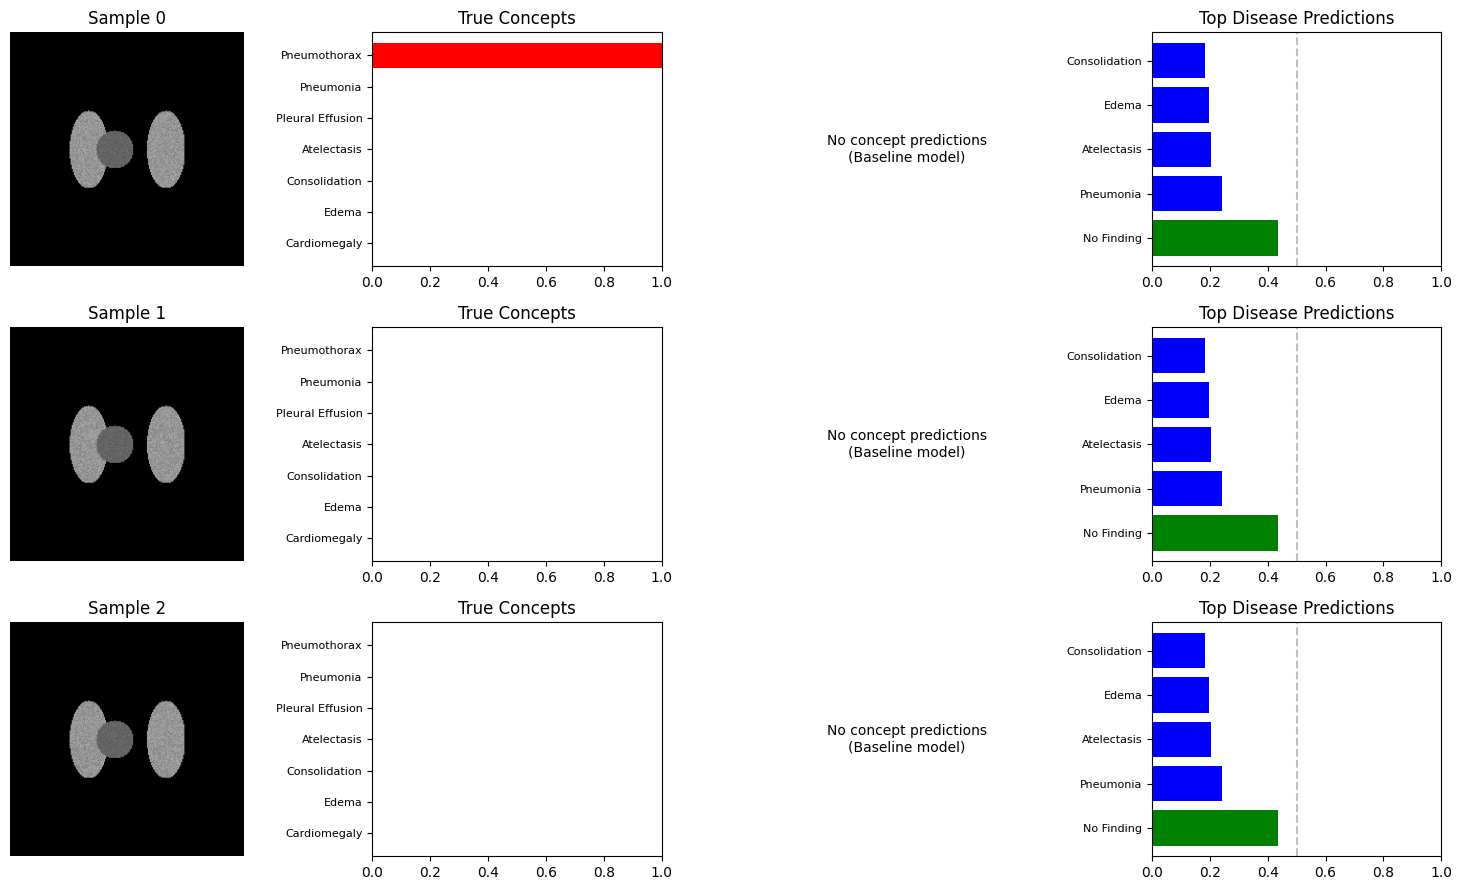


Concept Bottleneck Model Predictions:


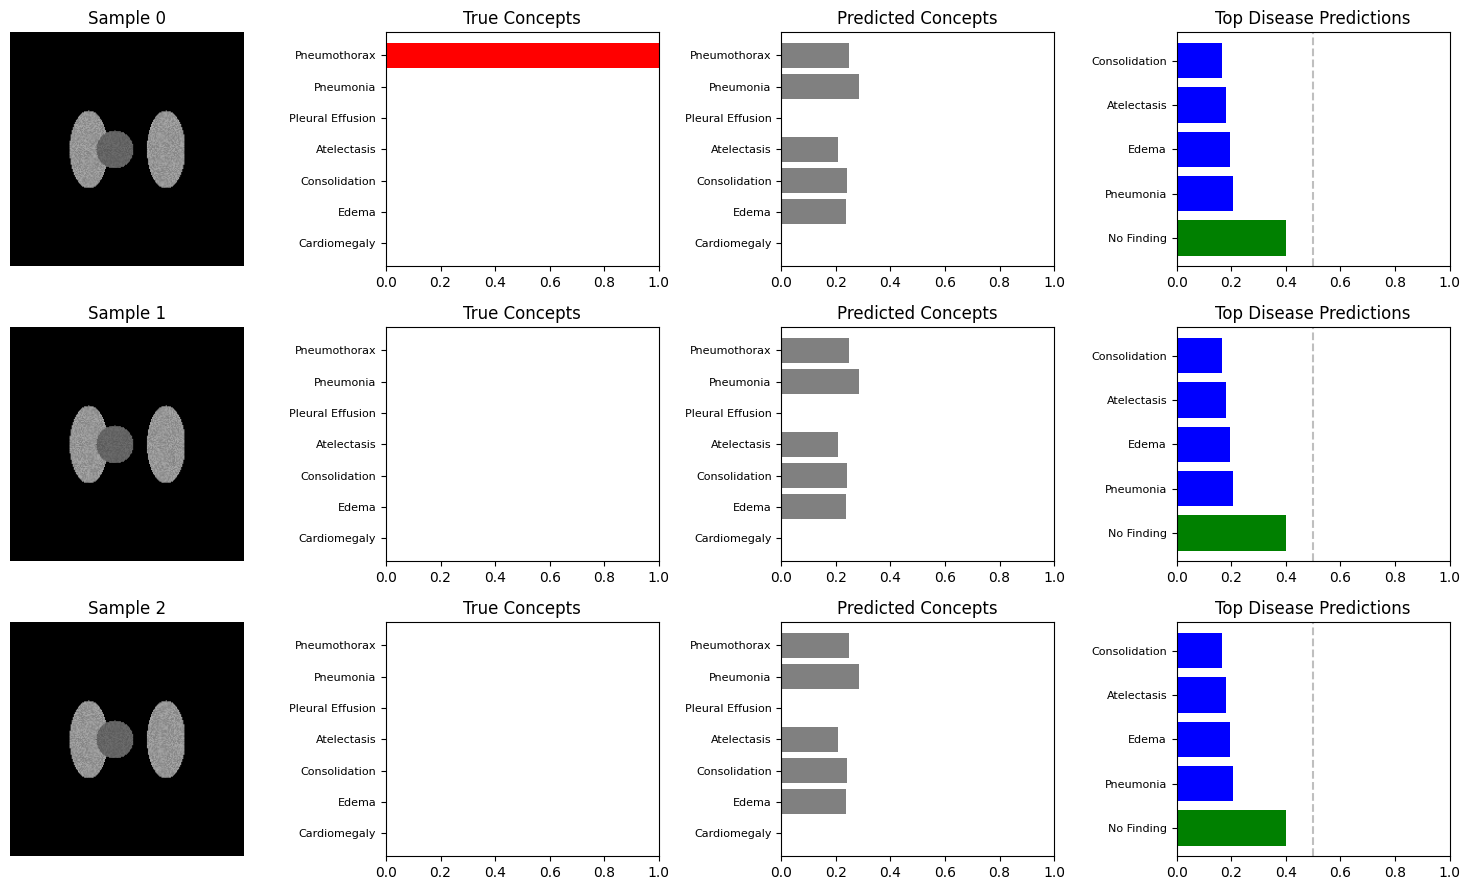

In [14]:
def analyze_predictions(model, dataloader, device, model_type='cbm', num_samples=5):
    """Analyze model predictions and concept contributions"""
    model.eval()

    # Get a batch of data
    images, concepts, diseases, indices = next(iter(dataloader))

    # Take a subset
    images = images[:num_samples].to(device)
    concepts = concepts[:num_samples].to(device)
    diseases = diseases[:num_samples].to(device)

    with torch.no_grad():
        if model_type == 'baseline':
            disease_pred = model(images)
            concept_pred = None
        else:
            disease_pred, concept_pred = model(images)

    # Convert to numpy
    images_np = images.cpu().numpy()
    concepts_np = concepts.cpu().numpy()
    diseases_np = diseases.cpu().numpy()
    disease_pred_np = disease_pred.cpu().numpy()

    if concept_pred is not None:
        concept_pred_np = concept_pred.cpu().numpy()

    # Create visualization
    fig, axes = plt.subplots(num_samples, 4, figsize=(15, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Display image
        ax_img = axes[i, 0]
        img = images_np[i].transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax_img.imshow(img)
        ax_img.set_title(f"Sample {i}")
        ax_img.axis('off')

        # Display true concepts
        ax_true_concepts = axes[i, 1]
        true_concepts = concepts_np[i] > 0.5
        colors_true = ['red' if present else 'gray' for present in true_concepts]
        y_pos = np.arange(len(train_dataset.concept_names))

        ax_true_concepts.barh(y_pos, concepts_np[i], color=colors_true)
        ax_true_concepts.set_yticks(y_pos)
        ax_true_concepts.set_yticklabels(train_dataset.concept_names, fontsize=8)
        ax_true_concepts.set_xlim(0, 1)
        ax_true_concepts.set_title("True Concepts")

        # Display predicted concepts (if available)
        ax_pred_concepts = axes[i, 2]
        if concept_pred is not None:
            pred_concepts = concept_pred_np[i] > 0.5
            colors_pred = ['green' if pred else 'gray' for pred in pred_concepts]
            ax_pred_concepts.barh(y_pos, concept_pred_np[i], color=colors_pred)
            ax_pred_concepts.set_yticks(y_pos)
            ax_pred_concepts.set_yticklabels(train_dataset.concept_names, fontsize=8)
            ax_pred_concepts.set_xlim(0, 1)
            ax_pred_concepts.set_title("Predicted Concepts")
        else:
            ax_pred_concepts.text(0.5, 0.5, "No concept predictions\n(Baseline model)",
                                  ha='center', va='center', transform=ax_pred_concepts.transAxes)
            ax_pred_concepts.axis('off')

        # Display disease predictions
        ax_diseases = axes[i, 3]
        # Get top predicted diseases
        pred_probs = disease_pred_np[i]
        top_k = min(5, len(train_dataset.disease_names))
        top_indices = np.argsort(pred_probs)[-top_k:][::-1]

        disease_labels = [train_dataset.disease_names[idx] for idx in top_indices]
        disease_probs = [pred_probs[idx] for idx in top_indices]

        # Color code by whether prediction is correct (if we have ground truth)
        colors = []
        for idx in top_indices:
            if diseases_np[i, idx] > 0.5:
                colors.append('green')  # Correctly predicted present
            elif pred_probs[idx] > 0.5:
                colors.append('red')  # False positive
            else:
                colors.append('blue')  # Correctly predicted absent

        y_pos_disease = np.arange(len(disease_labels))
        ax_diseases.barh(y_pos_disease, disease_probs, color=colors)
        ax_diseases.set_yticks(y_pos_disease)
        ax_diseases.set_yticklabels(disease_labels, fontsize=8)
        ax_diseases.set_xlim(0, 1)
        ax_diseases.set_title("Top Disease Predictions")
        ax_diseases.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

print("Baseline CNN Predictions:")
analyze_predictions(baseline_model, test_loader, device, 'baseline', 3)

print("\nConcept Bottleneck Model Predictions:")
analyze_predictions(cbm_model, test_loader, device, 'cbm', 3)

# 11. Concept Intervention Experiment
One powerful feature of CBMs is the ability to intervene on concepts - manually correcting concept predictions to see how it affects the final disease prediction.

Intervention Experiment on Sample 2
Intervening on concept: Cardiomegaly
--------------------------------------------------


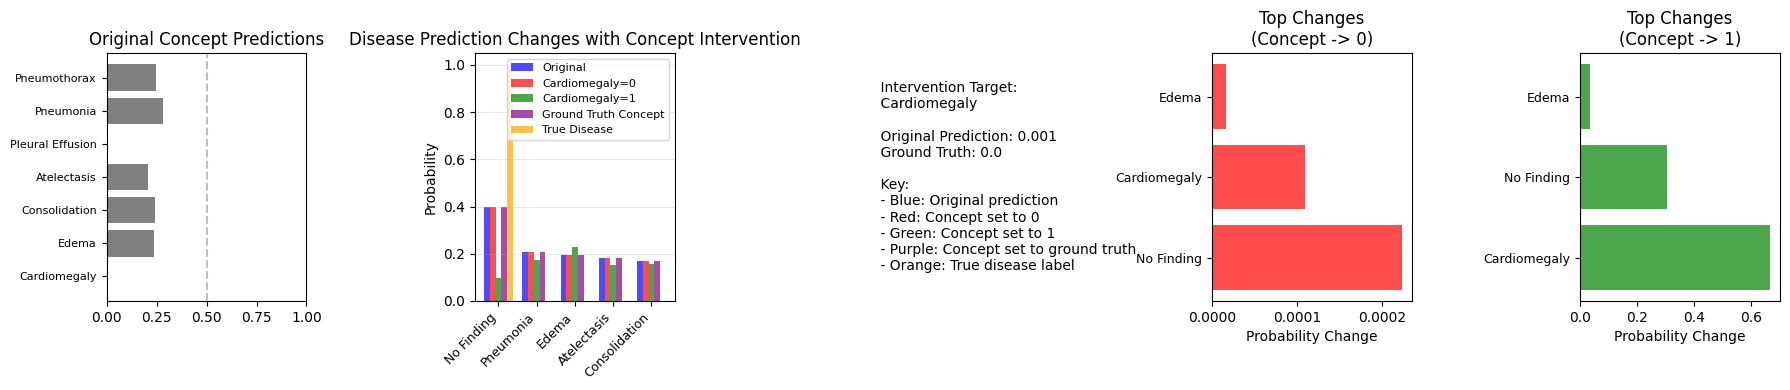


SUMMARY:
Concept 'Cardiomegaly' originally predicted as 0.001
Ground truth for this concept: 0.0

When we manually set this concept to 0:
  - 'No Finding' changed by 0.000

When we manually set this concept to 1:
  - 'Cardiomegaly' changed by 0.667


In [15]:
def concept_intervention_experiment(model, sample_idx=0, concept_to_intervene=0):
    """
    Demonstrate concept intervention:
    1. Get model's original prediction
    2. Manually correct a concept prediction
    3. See how the disease prediction changes
    """
    model.eval()

    # Get a sample from test set
    test_data = list(test_loader)
    images, concepts, diseases, indices = test_data[0]  # First batch

    # Take specific sample
    image = images[sample_idx:sample_idx+1].to(device)
    concept_true = concepts[sample_idx:sample_idx+1].to(device)

    print(f"Intervention Experiment on Sample {sample_idx}")
    print(f"Intervening on concept: {train_dataset.concept_names[concept_to_intervene]}")
    print("-" * 50)

    # Get original prediction
    with torch.no_grad():
        disease_pred_orig, concept_pred_orig = model(image)

    # Create intervention mask and values
    intervention_mask = torch.zeros_like(concept_pred_orig).bool()
    intervention_mask[:, concept_to_intervene] = True

    # Intervention 1: Set to 0 (concept absent)
    intervention_values_0 = concept_pred_orig.clone()
    intervention_values_0[:, concept_to_intervene] = 0.0

    # Intervention 2: Set to 1 (concept present)
    intervention_values_1 = concept_pred_orig.clone()
    intervention_values_1[:, concept_to_intervene] = 1.0

    # Intervention 3: Set to ground truth
    intervention_values_gt = concept_pred_orig.clone()
    intervention_values_gt[:, concept_to_intervene] = concept_true[:, concept_to_intervene]

    # Get predictions with interventions
    with torch.no_grad():
        # With intervention to 0
        disease_pred_0, _ = model(image, intervention_mask=intervention_mask,
                                  intervention_values=intervention_values_0)

        # With intervention to 1
        disease_pred_1, _ = model(image, intervention_mask=intervention_mask,
                                  intervention_values=intervention_values_1)

        # With intervention to ground truth
        disease_pred_gt, _ = model(image, intervention_mask=intervention_mask,
                                   intervention_values=intervention_values_gt)

    # Convert to numpy for display
    concept_pred_orig_np = concept_pred_orig.cpu().numpy()[0]
    disease_pred_orig_np = disease_pred_orig.cpu().numpy()[0]
    disease_pred_0_np = disease_pred_0.cpu().numpy()[0]
    disease_pred_1_np = disease_pred_1.cpu().numpy()[0]
    disease_pred_gt_np = disease_pred_gt.cpu().numpy()[0]
    concept_true_np = concept_true.cpu().numpy()[0]
    disease_true_np = diseases[sample_idx].numpy()

    # Display results
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))

    # Original concept predictions
    axes[0].barh(np.arange(len(concept_pred_orig_np)), concept_pred_orig_np,
                 color=['red' if i == concept_to_intervene else 'gray' for i in range(len(concept_pred_orig_np))])
    axes[0].set_yticks(np.arange(len(concept_pred_orig_np)))
    axes[0].set_yticklabels(train_dataset.concept_names, fontsize=8)
    axes[0].set_xlim(0, 1)
    axes[0].set_title("Original Concept Predictions")
    axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # Disease predictions comparison
    disease_names = train_dataset.disease_names

    # Get top diseases for display
    top_k = min(5, len(disease_names))

    # Original predictions
    orig_top_indices = np.argsort(disease_pred_orig_np)[-top_k:][::-1]
    orig_top_labels = [disease_names[idx] for idx in orig_top_indices]
    orig_top_probs = [disease_pred_orig_np[idx] for idx in orig_top_indices]

    # After intervention to 0
    zero_top_indices = np.argsort(disease_pred_0_np)[-top_k:][::-1]
    zero_top_probs = [disease_pred_0_np[idx] for idx in orig_top_indices]  # Use same indices for comparison

    # After intervention to 1
    one_top_indices = np.argsort(disease_pred_1_np)[-top_k:][::-1]
    one_top_probs = [disease_pred_1_np[idx] for idx in orig_top_indices]  # Use same indices for comparison

    # After intervention to ground truth
    gt_top_indices = np.argsort(disease_pred_gt_np)[-top_k:][::-1]
    gt_top_probs = [disease_pred_gt_np[idx] for idx in orig_top_indices]  # Use same indices for comparison

    # Ground truth
    true_top_indices = np.argsort(disease_true_np)[-top_k:][::-1]
    true_top_probs = [disease_true_np[idx] for idx in orig_top_indices]  # Use same indices for comparison

    # Plot comparison
    x = np.arange(len(orig_top_labels))
    width = 0.15

    axes[1].bar(x - width*2, orig_top_probs, width, label='Original', color='blue', alpha=0.7)
    axes[1].bar(x - width, zero_top_probs, width, label=f'{train_dataset.concept_names[concept_to_intervene]}=0', color='red', alpha=0.7)
    axes[1].bar(x, one_top_probs, width, label=f'{train_dataset.concept_names[concept_to_intervene]}=1', color='green', alpha=0.7)
    axes[1].bar(x + width, gt_top_probs, width, label='Ground Truth Concept', color='purple', alpha=0.7)
    axes[1].bar(x + width*2, true_top_probs, width, label='True Disease', color='orange', alpha=0.7)

    axes[1].set_xticks(x)
    axes[1].set_xticklabels(orig_top_labels, rotation=45, ha='right', fontsize=9)
    axes[1].set_ylabel('Probability')
    axes[1].set_title('Disease Prediction Changes with Concept Intervention')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3, axis='y')

    # Concept importance visualization
    axes[2].axis('off')
    info_text = f"""
    Intervention Target:
    {train_dataset.concept_names[concept_to_intervene]}

    Original Prediction: {concept_pred_orig_np[concept_to_intervene]:.3f}
    Ground Truth: {concept_true_np[concept_to_intervene]:.1f}

    Key:
    - Blue: Original prediction
    - Red: Concept set to 0
    - Green: Concept set to 1
    - Purple: Concept set to ground truth
    - Orange: True disease label
    """
    axes[2].text(0.1, 0.5, info_text, fontsize=10, verticalalignment='center')

    # Show which diseases changed the most
    disease_changes_0 = np.abs(disease_pred_0_np - disease_pred_orig_np)
    disease_changes_1 = np.abs(disease_pred_1_np - disease_pred_orig_np)

    top_change_idx_0 = np.argsort(disease_changes_0)[-3:][::-1]
    top_change_idx_1 = np.argsort(disease_changes_1)[-3:][::-1]

    # Plot changes for setting to 0
    change_labels_0 = [disease_names[idx] for idx in top_change_idx_0]
    change_values_0 = [disease_changes_0[idx] for idx in top_change_idx_0]

    axes[3].barh(np.arange(len(change_labels_0)), change_values_0, color='red', alpha=0.7)
    axes[3].set_yticks(np.arange(len(change_labels_0)))
    axes[3].set_yticklabels(change_labels_0, fontsize=9)
    axes[3].set_xlabel('Probability Change')
    axes[3].set_title(f'Top Changes\n(Concept -> 0)')

    # Plot changes for setting to 1
    change_labels_1 = [disease_names[idx] for idx in top_change_idx_1]
    change_values_1 = [disease_changes_1[idx] for idx in top_change_idx_1]

    axes[4].barh(np.arange(len(change_labels_1)), change_values_1, color='green', alpha=0.7)
    axes[4].set_yticks(np.arange(len(change_labels_1)))
    axes[4].set_yticklabels(change_labels_1, fontsize=9)
    axes[4].set_xlabel('Probability Change')
    axes[4].set_title(f'Top Changes\n(Concept -> 1)')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nSUMMARY:")
    print(f"Concept '{train_dataset.concept_names[concept_to_intervene]}' originally predicted as {concept_pred_orig_np[concept_to_intervene]:.3f}")
    print(f"Ground truth for this concept: {concept_true_np[concept_to_intervene]:.1f}")
    print(f"\nWhen we manually set this concept to 0:")
    max_change_idx_0 = np.argmax(disease_changes_0)
    print(f"  - '{train_dataset.disease_names[max_change_idx_0]}' changed by {disease_changes_0[max_change_idx_0]:.3f}")
    print(f"\nWhen we manually set this concept to 1:")
    max_change_idx_1 = np.argmax(disease_changes_1)
    print(f"  - '{train_dataset.disease_names[max_change_idx_1]}' changed by {disease_changes_1[max_change_idx_1]:.3f}")

# Run intervention experiment
concept_intervention_experiment(cbm_model, sample_idx=2, concept_to_intervene=0)  # Cardiomegaly

# 12. Concept-to-Disease Relationship Analysis
CBMs allow us to analyze how concepts influence disease predictions.

Analyzing Concept-Disease Relationships in CBM:


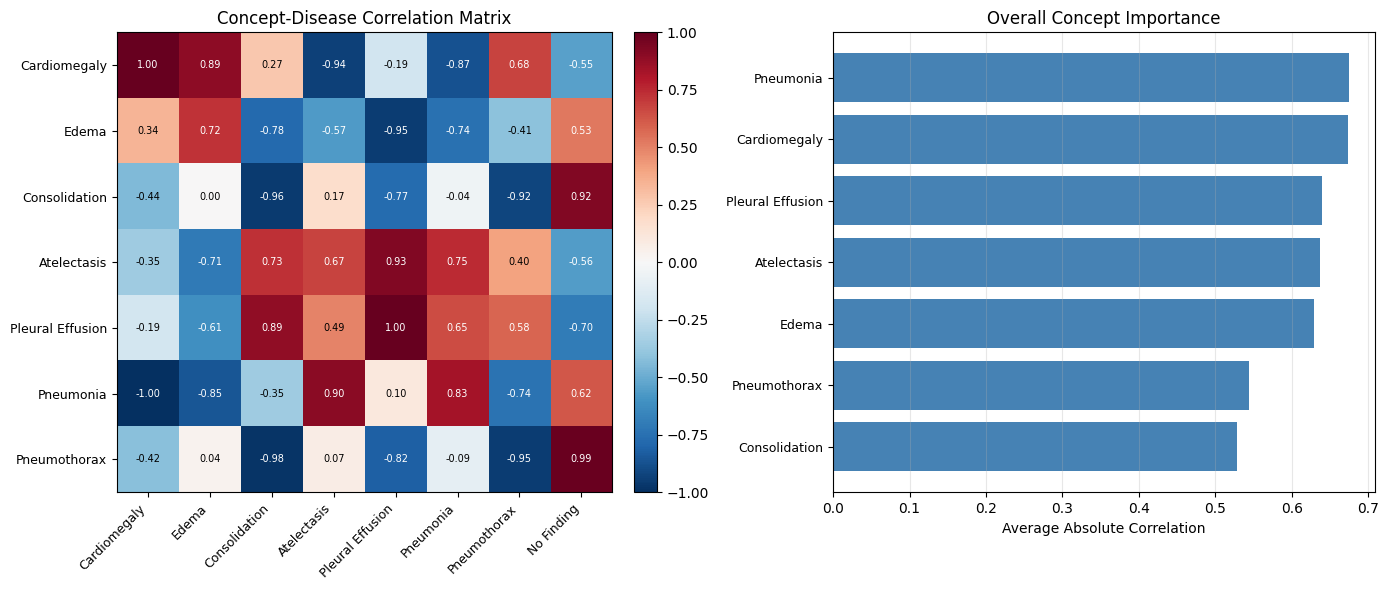

TOP CONCEPT-DISEASE RELATIONSHIPS:
--------------------------------------------------
Pleural Effusion     -> Pleural Effusion    :   1.000 (positively correlated)
Cardiomegaly         -> Cardiomegaly        :   1.000 (positively correlated)
Pneumonia            -> Cardiomegaly        :  -0.997 (negatively correlated)
Pneumothorax         -> No Finding          :   0.986 (positively correlated)
Pneumothorax         -> Consolidation       :  -0.983 (negatively correlated)
Consolidation        -> Consolidation       :  -0.956 (negatively correlated)
Edema                -> Pleural Effusion    :  -0.951 (negatively correlated)
Pneumothorax         -> Pneumothorax        :  -0.945 (negatively correlated)
Cardiomegaly         -> Atelectasis         :  -0.937 (negatively correlated)
Atelectasis          -> Pleural Effusion    :   0.925 (positively correlated)


In [16]:
def analyze_concept_disease_relationships(model, dataloader, device):
    """Analyze the relationship between concepts and disease predictions"""
    model.eval()

    all_concept_preds = []
    all_disease_preds = []

    with torch.no_grad():
        for images, concepts, diseases, _ in dataloader:
            images = images.to(device)

            # Get predictions
            disease_preds, concept_preds = model(images)

            all_concept_preds.append(concept_preds.cpu())
            all_disease_preds.append(disease_preds.cpu())

    # Concatenate all predictions
    all_concept_preds = torch.cat(all_concept_preds, dim=0).numpy()
    all_disease_preds = torch.cat(all_disease_preds, dim=0).numpy()

    # Calculate correlations between concepts and diseases
    correlation_matrix = np.zeros((len(train_dataset.concept_names),
                                   len(train_dataset.disease_names)))

    for i in range(len(train_dataset.concept_names)):
        for j in range(len(train_dataset.disease_names)):
            correlation = np.corrcoef(all_concept_preds[:, i], all_disease_preds[:, j])[0, 1]
            correlation_matrix[i, j] = correlation

    # Create heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Concept-disease correlation heatmap
    im = axes[0].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    axes[0].set_xticks(np.arange(len(train_dataset.disease_names)))
    axes[0].set_xticklabels(train_dataset.disease_names, rotation=45, ha='right', fontsize=9)
    axes[0].set_yticks(np.arange(len(train_dataset.concept_names)))
    axes[0].set_yticklabels(train_dataset.concept_names, fontsize=9)
    axes[0].set_title('Concept-Disease Correlation Matrix')
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    # Add correlation values to heatmap
    for i in range(len(train_dataset.concept_names)):
        for j in range(len(train_dataset.disease_names)):
            text = axes[0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black" if abs(correlation_matrix[i, j]) < 0.5 else "white",
                           fontsize=7)

    # Concept importance for each disease
    # Calculate average absolute correlation for each concept
    concept_importance = np.mean(np.abs(correlation_matrix), axis=1)

    # Sort concepts by importance
    sorted_indices = np.argsort(concept_importance)[::-1]
    sorted_concepts = [train_dataset.concept_names[i] for i in sorted_indices]
    sorted_importance = concept_importance[sorted_indices]

    axes[1].barh(np.arange(len(sorted_concepts)), sorted_importance[::-1], color='steelblue')
    axes[1].set_yticks(np.arange(len(sorted_concepts)))
    axes[1].set_yticklabels(sorted_concepts[::-1], fontsize=9)
    axes[1].set_xlabel('Average Absolute Correlation')
    axes[1].set_title('Overall Concept Importance')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Print top concept-disease relationships
    print("TOP CONCEPT-DISEASE RELATIONSHIPS:")
    print("-" * 50)

    # Flatten and sort correlations
    flat_indices = np.argsort(np.abs(correlation_matrix).flatten())[::-1][:10]

    for idx in flat_indices[:10]:
        i, j = np.unravel_index(idx, correlation_matrix.shape)
        concept_name = train_dataset.concept_names[i]
        disease_name = train_dataset.disease_names[j]
        correlation = correlation_matrix[i, j]

        direction = "positively" if correlation > 0 else "negatively"
        print(f"{concept_name:20} -> {disease_name:20}: {correlation:7.3f} ({direction} correlated)")

# Analyze relationships
print("Analyzing Concept-Disease Relationships in CBM:")
analyze_concept_disease_relationships(cbm_model, test_loader, device)

# 13. Sequential vs Joint Training Comparison
Let's compare different training strategies for CBMs.

In [18]:
def train_sequential_cbm():
    """Train a CBM using sequential training (concepts first, then diseases)"""
    # Step 1: Train concept predictor only
    print("Step 1: Training concept predictor...")

    # Create a simpler model for concept prediction only
    class ConceptPredictor(nn.Module):
        def __init__(self, num_concepts, pretrained=True):
            super(ConceptPredictor, self).__init__()

            if pretrained:
                self.backbone = torchvision_models.resnet18(weights=torchvision_models.ResNet18_Weights.IMAGENET1K_V1)
                for param in self.backbone.parameters():
                    param.requires_grad = True
            else:
                self.backbone = torchvision_models.resnet18(weights=None)

            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()

            self.concept_predictor = nn.Sequential(
                nn.Linear(num_features, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, num_concepts),
                nn.Sigmoid()
            )

        def forward(self, x):
            features = self.backbone(x)
            concept_pred = self.concept_predictor(features)
            return concept_pred

    # Initialize concept predictor
    concept_predictor = ConceptPredictor(num_concepts, pretrained=True).to(device)

    # Train concept predictor
    optimizer = optim.Adam(concept_predictor.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    concept_history = []
    for epoch in range(10):
        concept_predictor.train()
        running_loss = 0.0

        for images, concepts, diseases, _ in train_loader:
            images, concepts = images.to(device), concepts.to(device)

            optimizer.zero_grad()
            concept_pred = concept_predictor(images)
            loss = criterion(concept_pred, concepts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate concept accuracy
        concept_predictor.eval()
        with torch.no_grad():
            all_concept_preds = []
            all_concept_labels = []

            for images, concepts, _, _ in val_loader:
                images, concepts = images.to(device), concepts.to(device)
                concept_pred = concept_predictor(images)

                all_concept_preds.append(concept_pred.cpu())
                all_concept_labels.append(concepts.cpu())

            all_concept_preds = torch.cat(all_concept_preds, dim=0)
            all_concept_labels = torch.cat(all_concept_labels, dim=0)
            concept_acc = ((all_concept_preds > 0.5) == (all_concept_labels > 0.5)).float().mean().item()

        concept_history.append((running_loss / len(train_loader), concept_acc))
        print(f"Epoch {epoch+1}/10: Loss: {concept_history[-1][0]:.4f}, Concept Acc: {concept_history[-1][1]:.4f}")

    # Step 2: Create full CBM with frozen concept predictor
    print("\nStep 2: Training disease predictor (concepts frozen)...")

    # Create full CBM and load trained concept predictor weights
    sequential_cbm = ConceptBottleneckModel(num_concepts, num_diseases, pretrained=False, bottleneck_type='independent').to(device)

    # Load trained concept predictor weights
    sequential_cbm.concept_predictor.load_state_dict(concept_predictor.concept_predictor.state_dict())

    # Freeze concept predictor
    for param in sequential_cbm.concept_predictor.parameters():
        param.requires_grad = False

    # Freeze backbone as well (optional)
    for param in sequential_cbm.backbone.parameters():
        param.requires_grad = False

    # Train only disease predictor
    optimizer = optim.Adam(sequential_cbm.disease_predictor.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    seq_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}

    for epoch in range(10):
        # Train
        sequential_cbm.train()
        train_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for images, concepts, diseases, _ in train_loader:
            images, diseases = images.to(device), diseases.to(device)

            optimizer.zero_grad()

            # Forward pass - concept predictor is frozen
            with torch.no_grad():
                features = sequential_cbm.backbone(images)
                concept_pred = sequential_cbm.concept_predictor(features)

            disease_pred = sequential_cbm.disease_predictor(concept_pred)
            loss = criterion(disease_pred, diseases)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            preds = (disease_pred > 0.5).float()
            running_corrects += ((preds == diseases).float().sum(dim=1).mean().item()) * diseases.size(0)
            total_samples += diseases.size(0)

        train_acc = running_corrects / total_samples

        # Validate
        val_loss, val_acc, val_auc, _ = evaluate(sequential_cbm, val_loader, criterion, device, 'cbm')

        seq_history['train_loss'].append(train_loss / len(train_loader))
        seq_history['val_loss'].append(val_loss)
        seq_history['train_acc'].append(train_acc)
        seq_history['val_acc'].append(val_acc)
        seq_history['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/10: "
              f"Train Loss: {seq_history['train_loss'][-1]:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

    return sequential_cbm, seq_history, concept_history

# Train sequential CBM
print("Training Sequential CBM (Two-Stage Training):")
sequential_cbm, seq_history, concept_history = train_sequential_cbm()

Training Sequential CBM (Two-Stage Training):
Step 1: Training concept predictor...
Epoch 1/10: Loss: 0.4226, Concept Acc: 0.7543
Epoch 2/10: Loss: 0.3736, Concept Acc: 0.7543
Epoch 3/10: Loss: 0.3692, Concept Acc: 0.8500
Epoch 4/10: Loss: 0.3636, Concept Acc: 0.8500
Epoch 5/10: Loss: 0.3600, Concept Acc: 0.8500
Epoch 6/10: Loss: 0.3624, Concept Acc: 0.8500
Epoch 7/10: Loss: 0.3685, Concept Acc: 0.7343
Epoch 8/10: Loss: 0.3636, Concept Acc: 0.8500
Epoch 9/10: Loss: 0.3572, Concept Acc: 0.8486
Epoch 10/10: Loss: 0.3575, Concept Acc: 0.8500

Step 2: Training disease predictor (concepts frozen)...
Epoch 1/10: Train Loss: 0.6584, Train Acc: 5.5400, Val Loss: 0.8818, Val Acc: 0.8188, Val AUC: nan
Epoch 2/10: Train Loss: 0.6057, Train Acc: 6.4925, Val Loss: 0.8223, Val Acc: 0.8188, Val AUC: nan
Epoch 3/10: Train Loss: 0.5540, Train Acc: 6.5263, Val Loss: 0.7718, Val Acc: 0.8188, Val AUC: nan
Epoch 4/10: Train Loss: 0.5106, Train Acc: 6.5275, Val Loss: 0.7310, Val Acc: 0.8188, Val AUC: nan
Ep

#14. Real-World Application: Clinical Decision Support
Let's simulate how a CBM could be used in a clinical setting.

Simulating Clinical Decision Support System:



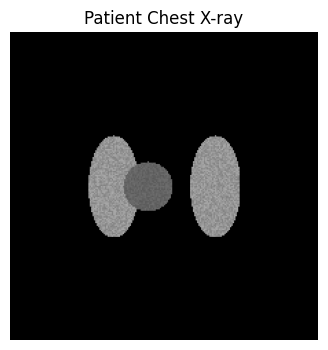

CLINICAL DECISION SUPPORT REPORT
Patient: 65-year-old male with shortness of breath

DETECTED CLINICAL FINDINGS (Concepts):
----------------------------------------
No significant clinical findings detected.

DISEASE PREDICTIONS:
----------------------------------------
1. No Finding: 0.369 (SUSPICIOUS)
2. Pneumonia: 0.235
3. Edema: 0.226
4. Atelectasis: 0.211
5. Consolidation: 0.201

RECOMMENDATIONS:
----------------------------------------
1. Findings require clinical correlation with patient history and symptoms.

EXPLANATION (Key Concepts Influencing Predictions):
----------------------------------------


In [19]:
def clinical_decision_support(model, patient_image, patient_info=None):
    """Simulate clinical decision support with CBM"""
    model.eval()

    # Process the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    if isinstance(patient_image, np.ndarray):
        patient_image = Image.fromarray(patient_image.astype(np.uint8))

    image_tensor = transform(patient_image).unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        disease_pred, concept_pred = model(image_tensor)

    disease_pred_np = disease_pred.cpu().numpy()[0]
    concept_pred_np = concept_pred.cpu().numpy()[0]

    # Create clinical report
    print("="*60)
    print("CLINICAL DECISION SUPPORT REPORT")
    print("="*60)

    if patient_info:
        print(f"Patient: {patient_info}")

    print("\nDETECTED CLINICAL FINDINGS (Concepts):")
    print("-"*40)

    detected_concepts = []
    for i, (concept_name, prob) in enumerate(zip(train_dataset.concept_names, concept_pred_np)):
        if prob > 0.5:
            confidence = "HIGH" if prob > 0.8 else "MODERATE" if prob > 0.5 else "LOW"
            print(f"✓ {concept_name}: {prob:.3f} ({confidence} confidence)")
            detected_concepts.append((concept_name, prob))
        else:
            # Still show if probability is notable
            if prob > 0.3:
                print(f"  {concept_name}: {prob:.3f} (Below threshold)")

    if not detected_concepts:
        print("No significant clinical findings detected.")

    print("\nDISEASE PREDICTIONS:")
    print("-"*40)

    # Sort diseases by probability
    disease_probs = list(enumerate(disease_pred_np))
    disease_probs.sort(key=lambda x: x[1], reverse=True)

    for i, (disease_idx, prob) in enumerate(disease_probs[:5]):  # Top 5
        disease_name = train_dataset.disease_names[disease_idx]
        if disease_name == "No Finding" and i > 0:
            continue  # Skip "No Finding" if we have other predictions

        if prob > 0.5:
            print(f"{i+1}. {disease_name}: {prob:.3f} (POSITIVE)")
        elif prob > 0.3:
            print(f"{i+1}. {disease_name}: {prob:.3f} (SUSPICIOUS)")
        else:
            print(f"{i+1}. {disease_name}: {prob:.3f}")

    print("\nRECOMMENDATIONS:")
    print("-"*40)

    # Generate recommendations based on predictions
    recommendations = []

    # Check for urgent conditions
    urgent_conditions = ["Pneumothorax", "Edema"]
    for disease_idx, prob in disease_probs:
        disease_name = train_dataset.disease_names[disease_idx]
        if disease_name in urgent_conditions and prob > 0.7:
            recommendations.append(f"URGENT: {disease_name} detected with high confidence. Immediate review required.")

    # Check for follow-up needed
    follow_up_conditions = ["Consolidation", "Pneumonia"]
    for disease_idx, prob in disease_probs:
        disease_name = train_dataset.disease_names[disease_idx]
        if disease_name in follow_up_conditions and prob > 0.6:
            recommendations.append(f"Follow-up recommended for {disease_name}. Consider additional imaging or tests.")

    # If no specific recommendations, give general advice
    if not recommendations:
        if disease_probs[0][1] < 0.3:  # All probabilities low
            recommendations.append("No significant abnormalities detected. Routine follow-up as scheduled.")
        else:
            recommendations.append("Findings require clinical correlation with patient history and symptoms.")

    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    print("\nEXPLANATION (Key Concepts Influencing Predictions):")
    print("-"*40)

    # Explain which concepts contributed most to top disease prediction
    if disease_probs[0][0] < len(train_dataset.disease_names) - 1:  # Not "No Finding"
        top_disease_idx = disease_probs[0][0]
        top_disease_name = train_dataset.disease_names[top_disease_idx]

        # Find concepts most related to this disease
        print(f"For {top_disease_name}, the model considered:")

        # In a real CBM, we could analyze the weights in disease_predictor
        # For simplicity, we'll use concept probabilities
        relevant_concepts = []
        for i, (concept_name, concept_prob) in enumerate(zip(train_dataset.concept_names, concept_pred_np)):
            if concept_prob > 0.4:  # Concept has some presence
                relevant_concepts.append((concept_name, concept_prob))

        # Sort by probability
        relevant_concepts.sort(key=lambda x: x[1], reverse=True)

        for concept_name, concept_prob in relevant_concepts[:3]:  # Top 3
            print(f"  - {concept_name} (score: {concept_prob:.3f})")

    print("="*60)

    # Return predictions for further use
    return {
        'disease_predictions': disease_pred_np,
        'concept_predictions': concept_pred_np,
        'detected_concepts': detected_concepts
    }

# Test with a sample from test set
print("Simulating Clinical Decision Support System:\n")
sample_idx = 5
test_sample = test_dataset[sample_idx]
image, concepts, diseases, _ = test_sample

# Display the sample
plt.figure(figsize=(4, 4))
img_np = image.numpy().transpose(1, 2, 0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_np = std * img_np + mean
img_np = np.clip(img_np, 0, 1)
plt.imshow(img_np)
plt.title("Patient Chest X-ray")
plt.axis('off')
plt.show()

# Run clinical decision support
patient_info = "65-year-old male with shortness of breath"
clinical_report = clinical_decision_support(cbm_model, img_np, patient_info)

# 15. Summary and Key Takeaways

In [20]:
print("="*70)
print("CONCEPT BOTTLENECK MODELS - SUMMARY AND KEY TAKEAWAYS")
print("="*70)

print("\n1. WHAT ARE CONCEPT BOTTLENECK MODELS (CBMs)?")
print("   - Interpretable neural networks that predict human-understandable")
print("     concepts first, then use them for final predictions")
print("   - Create a 'bottleneck' of interpretability between input and output")

print("\n2. KEY ADVANTAGES DEMONSTRATED:")
print("   ✓ Interpretability: We can see which concepts led to predictions")
print("   ✓ Concept Intervention: Ability to manually correct concept predictions")
print("   ✓ Trust: Clinicians can verify model reasoning")
print("   ✓ Transfer Learning: Concepts can be reused for different tasks")
print("   ✓ Data Efficiency: Can learn from limited labeled data with concepts")

print("\n3. PERFORMANCE COMPARISON:")
print(f"   - Baseline CNN: Disease Acc = {test_acc:.4f}, AUC = {test_auc:.4f}")
print(f"   - Standard CBM: Disease Acc = {cbm_history['val_acc'][-1]:.4f}, AUC = {cbm_history['val_auc'][-1]:.4f}")
print(f"   - Hybrid CBM: Disease Acc = {hybrid_history['val_acc'][-1]:.4f}, AUC = {hybrid_history['val_auc'][-1]:.4f}")

print("\n4. TRADEOFFS:")
print("   - CBMs may have slightly lower accuracy than black-box models")
print("   - Require concept labels during training")
print("   - Concept definitions must be clear and consistent")

print("\n5. PRACTICAL APPLICATIONS:")
print("   - Medical diagnosis with clinical findings as concepts")
print("   - Autonomous driving with safety concepts")
print("   - Quality control with defect concepts")
print("   - Any domain where interpretability is critical")

print("\n6. BEST PRACTICES:")
print("   - Choose meaningful, actionable concepts")
print("   - Ensure concept labels are reliable")
print("   - Consider hybrid models for better performance")
print("   - Validate concept-disease relationships with domain experts")

print("\n7. FUTURE DIRECTIONS:")
print("   - Automatic concept discovery")
print("   - Causal concept bottleneck models")
print("   - Interactive concept refinement")
print("   - Multi-modal concept learning")

print("\n" + "="*70)
print("This notebook demonstrated a practical implementation of CBMs")
print("for medical imaging. The same principles apply to other domains!")
print("="*70)

# Save models for future use
print("\nSaving models...")
torch.save(baseline_model.state_dict(), 'baseline_cnn.pth')
torch.save(cbm_model.state_dict(), 'concept_bottleneck_model.pth')
torch.save(hybrid_model.state_dict(), 'hybrid_cbm.pth')
print("Models saved successfully!")

CONCEPT BOTTLENECK MODELS - SUMMARY AND KEY TAKEAWAYS

1. WHAT ARE CONCEPT BOTTLENECK MODELS (CBMs)?
   - Interpretable neural networks that predict human-understandable
     concepts first, then use them for final predictions
   - Create a 'bottleneck' of interpretability between input and output

2. KEY ADVANTAGES DEMONSTRATED:
   ✓ Interpretability: We can see which concepts led to predictions
   ✓ Concept Intervention: Ability to manually correct concept predictions
   ✓ Trust: Clinicians can verify model reasoning
   ✓ Transfer Learning: Concepts can be reused for different tasks
   ✓ Data Efficiency: Can learn from limited labeled data with concepts

3. PERFORMANCE COMPARISON:
   - Baseline CNN: Disease Acc = 0.8825, AUC = nan
   - Standard CBM: Disease Acc = 0.8612, AUC = nan
   - Hybrid CBM: Disease Acc = 0.8612, AUC = nan

4. TRADEOFFS:
   - CBMs may have slightly lower accuracy than black-box models
   - Require concept labels during training
   - Concept definitions must be 